# Emergent constraints on air-sea fluxes

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import emergent_constraint as ec
import figure_panels
import obs_aircraft
import util

## Set up emergent constraint computation

In [4]:
air_parms = ec.get_parameters('default')
air_parms

{'ubin': 300.0,
 'lbin': 280.0,
 'udθ': 10.0,
 'lbin_as_upper_bound': True,
 'ubin_as_lower_bound': False,
 'gradient_lat_range': (-90.0, -45.0),
 'flux_lat_range': (-90.0, -45.0),
 'flux_memory': 90,
 'fit_groups': ('DJF', 'MAMJJASON')}

In [5]:
clobber = False
clobber_deep = False


obj_srf = {}; obj_air = {};
acs = {}; scs = {};
for constraint_type in ['ocean_constraint', 'total_constraint',]:
    model_input_lists = ec.get_model_tracer_lists(constraint_type)
    obj_srf[constraint_type] = ec.whole_enchilada_srf(**model_input_lists)
    obj_air[constraint_type] = ec.whole_enchilada(clobber=clobber_deep, **model_input_lists)
    
    acs[constraint_type] = obj_air[constraint_type].get_ac(**air_parms, clobber=clobber)
    scs[constraint_type] = obj_srf[constraint_type].get_sc(clobber=clobber)

## Fig 3: flux-gradient relationships

xlim air_sum: [-1.396637  0.354277]
xlim air_win: [-0.70587225  0.30441725]
xlim srf_sum: [-0.31971167  0.01522437]
xlim srf_win: [-0.08157546  0.05080845]
xlim set span air_sum: [2.06]
xlim set span air_win: [1.07]
xlim set span srf_sum: [0.51]
xlim set span srf_win: [0.51]


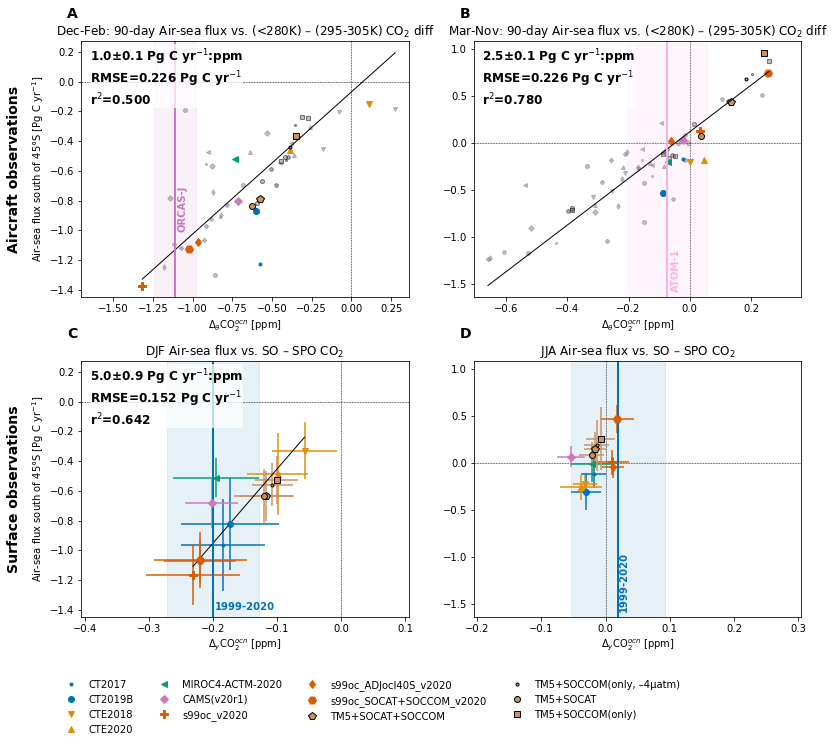

In [6]:
def plot_flux_v_gradient(constraint_type):
    
    ac = acs[constraint_type]
    sc = scs[constraint_type]
    
    fig = plt.figure(figsize=(10, 8)) #dpi=300)
    gs = gridspec.GridSpec(
        nrows=2, ncols=2, 
        left=0, right=1,
        bottom=0., top=1,
        hspace=0.25, wspace=0.2,
    )

    theta_centers = [np.mean(t) for t in ac.theta_bins]
    fit_groups = ac.fit_groups
    i_campaign = ac.df_data.xs((fit_groups[0]), level=('campaign_group')).index.names.index('campaign')

    assert len(fit_groups) == 2

    subplots = ['air_sum', 'air_win', 'srf_sum', 'srf_win',]

    nrow = 2
    ncol = 2

    axs = {
        subplots[i*2+j]: plt.subplot(gs[i, j]) 
        for i, j in product(range(nrow), range(ncol))
    }

    theta_str = figure_panels.theta_bin_def(ac.theta_bins)
    if constraint_type == 'ocean_constraint':
        flux_type = 'Air-sea'
    else:
        flux_type = 'Surface'

    str_co2 = 'CO$_2^{ocn}$' if constraint_type == 'ocean_constraint' else 'CO$_2$'

    kwargs_dict = dict(
        srf_sum=dict(
            title=f'DJF {flux_type} flux vs. SO – SPO CO$_2$',
            xlabel='$\Delta_{ y}$' + str_co2 + ' [ppm]',
            df_data=sc.df_data.xs(('1999-2020', 'DJF'), level=['period', 'season']),        
            fit_dict=ec.get_fit_dict(sc.df_fits.loc[('1999-2020', 'DJF')]),
        ), 
        air_sum=dict(
            title=f'Dec-Feb: 90-day {flux_type} flux vs. {theta_str} CO$_2$ diff',
            xlabel='$\Delta_{ θ}$' + str_co2 + ' [ppm]',
            highlight_campaign=['ORCAS-F'],
            df_data=ac.df_data.xs('DJF', level='campaign_group'),        
            fit_dict=ec.get_fit_dict(ac.df_fits.loc['DJF']),
        ),
        srf_win=dict(
            title=f'JJA {flux_type} flux vs. SO – SPO CO$_2$',
            xlabel='$\Delta_{ y}$' + str_co2 + ' [ppm]',
            df_data=sc.df_data.xs(('1999-2020', 'JJA'), level=['period', 'season']),
            fit_dict=ec.get_fit_dict(sc.df_fits.loc[('1999-2020', 'JJA')]),
        ),      
        air_win=dict(
            title=f'Mar-Nov: 90-day {flux_type} flux vs. {theta_str} CO$_2$ diff',
            xlabel='$\Delta_{ θ}$' + str_co2 + ' [ppm]',
            highlight_campaign=['ATOM-1'],        
            df_data=ac.df_data.xs('MAMJJASON', level='campaign_group'),
            fit_dict=ec.get_fit_dict(ac.df_fits.loc['MAMJJASON']),
        ),
    )

    xlm = {}; ylm = {};  eq_text = {}
    plotted_elements = []; legend_elements = [];
    for n, k in enumerate(subplots):
        kwargs = {key: val for key, val in kwargs_dict[k].items()}
        i, j = np.unravel_index(n, (nrow, ncol))
        if j == 0:
            kwargs['ylabel'] = f'{flux_type} flux south of 45°S [Pg C yr$^{{-1}}$]'
            
        kwargs['circle_one'] = ['sEXTocNEET_SOCCOM_v2020',] #'CarboScope', 'CarboScopeAdjSO', 'sEXTocNEET_SOCCOM_v2020',]

        le, pe, eq_text[k] = ec.plot_constraint(axs[k], plotted_elements=plotted_elements, **kwargs)
        legend_elements.extend(le); plotted_elements.extend(pe)    
        xlm[k] = np.array(axs[k].get_xlim())    
        ylm[k] = np.array(axs[k].get_ylim())    
        print(f'xlim {k}: {xlm[k]}')

    def get_ax_lim(keys):
        bnd = lambda lm: (np.min([lm[k][0] for k in keys]), np.max([lm[k][1] for k in keys]))
        return bnd(xlm), bnd(ylm)

    xlm_summer, ylm_summer  = get_ax_lim([k for k in subplots if '_sum' in k])
    xlm_winter, ylm_winter  = get_ax_lim([k for k in subplots if '_win' in k])
    
    set_ylm = dict(
        srf_sum=ylm_summer, 
        air_sum=ylm_summer, 
        srf_win=ylm_winter, 
        air_win=ylm_winter,
    )
    set_xlm = {}
    if constraint_type == 'ocean_constraint':
        set_xlm = dict(
            srf_sum=(-0.405, 0.105),  #(-0.405, 0.095), 
            srf_win=(-0.205, 0.305),  #(-0.405, 0.095),     
            air_sum=(-1.7, 0.36), 
            air_win=(-0.705, 0.365),
        )
    elif constraint_type == 'total_constraint':
         set_xlm = dict(
             srf_sum=(-0.45, 0.05),  #(-0.405, 0.095), 
             srf_win=(-0.25, 0.25),  #(-0.405, 0.095),     
             air_sum=(-1.48, 0.51), 
             air_win=(-1.04, 0.22),
         )\

    
    for k in subplots: 
        if k in set_xlm: 
            if not xlm[k][0] >= set_xlm[k][0]:
                print(f'WARNING: {k}: xbound[0] truncated: def: {xlm[k][0]} set: {set_xlm[k][0]}')
            
            if not xlm[k][1] <= set_xlm[k][1]:
                print(f'WARNING: {k}: xbound[1] truncated: def: {xlm[k][1]} set: {set_xlm[k][1]}')
            print(f'xlim set span {k}: {np.diff(set_xlm[k])}')                
            axs[k].set_xlim(set_xlm[k])
                    
        if k in set_ylm:
            if not ylm[k][0] >= set_ylm[k][0]:
                print(f'WARNING: {k}: ybound[0] truncated: def: {ylm[k][0]} set: {set_ylm[k][0]}')
            if not ylm[k][1] <= set_ylm[k][1]:
                print(f'WARNING: {k}: ybound[1] truncated: def: {ylm[k][1]} set: {set_ylm[k][1]}')   
            axs[k].set_ylim(set_ylm[k])
        
        if eq_text[k] is not None:
            xlim = np.array(axs[k].get_xlim())
            ylim = np.array(axs[k].get_ylim())            
            xtxt = xlim[0] + np.diff(xlim) * 0.025            
            ytxt = ylim[1] - np.diff(ylim) * 0.25                      
            eq_text[k].set_position((xtxt, ytxt))

    if constraint_type in ['ocean_constraint', 'total_constraint']:
        ec.add_obs_constraint(
            ax=axs['srf_sum'], 
            df=sc.surface_flux, 
            indexes=[('1999-2020', 'DJF')], 
            marker_spec={},
            labels=['1999-2020',],
            label_dx={'1999-2020': 0.05},
            #label_dy={'1999-2020': 0.87},    
            rotation={'1999-2020': 0.0},
        )
        ec.add_obs_constraint(
            ax=axs['air_sum'], 
            df=ac.campaign_flux, 
            indexes=['ORCAS-J',], 
            marker_spec=figure_panels.marker_spec_campaigns(),
            labels=['ORCAS-J',],
            label_dx={'ORCAS-J': 0.05},    
            label_dy={'ORCAS-J': 0.45},        
        )
        ec.add_obs_constraint(
            ax=axs['srf_win'], 
            df=sc.surface_flux,
            indexes=[('1999-2020', 'JJA')], 
            marker_spec={},
            labels=['1999-2020'],
            label_dx={'1999-2020': 0.01},
        )
        ec.add_obs_constraint(
            ax=axs['air_win'], 
            df=ac.campaign_flux, 
            indexes=['ATOM-1', ], 
            marker_spec=figure_panels.marker_spec_campaigns(),
            labels=['ATOM-1',],
            label_dx={'ATOM-1': 0.03},
        )

    axs[subplots[-1]].legend(handles=legend_elements, ncol=4, loc=(-1.275, -0.475), frameon=False)

    # add annotations
    # util.subplot_col_labels(
    #     [axs[subplots[j]] for j in range(ncol)], 
    #     ['Summer', '']
    # )
    util.subplot_row_labels(
        [axs[subplots[i*ncol]] for i in range(nrow)], 
        ['Aircraft observations', 'Surface observations']
    )

    fit_campaigns = {}
    fit_ax_props = {}
    fit_copy_properties = ['xlim', 'ylim', 'xticks', 'yticks']
    for i, fit_group in enumerate(fit_groups):
        fit_campaigns[fit_group] = util.list_set(
            [ndx[i_campaign] for ndx in ac.df_data.xs((fit_group), level=('campaign_group')).index]
        )
        ax = axs[[k for k in subplots if 'air_' in k][i]]
        fit_ax_props[fit_group] = {p: plt.getp(ax, p) for p in fit_copy_properties}

    util.label_plots(fig, [axs[k] for k in subplots], xoff=-0.02, yoff=0.04)

    return fit_campaigns, fit_ax_props

constraint_type = 'ocean_constraint'
fit_campaigns_ocn, fit_ax_props_ocn = plot_flux_v_gradient(constraint_type)
util.savefig(f'emergent-constraint-{constraint_type}.pdf')

**Emergent constraints on air-sea fluxes south of 45°S.** Upper panels: 90-day-mean air-sea fluxes south of 45°S versus ∆θCO<sub>2</sub>ocn from model simulations (see SM) replicating aircraft observations collected during (A) Dec-Feb and (B) Mar-Nov. Colored vertical lines show an observed value of $\Delta_{\theta}\ce{CO}_2$ (ORCAS during Jan in panel “A” and ATom-1 in panel “B”) corrected for land and fossil-fuel influence, with shading indicating both analytical uncertainty and model spread in the correction; colored points highlight the model samples from these particular campaigns, while gray points show data from other campaigns in the (A) Dec–Feb or (B) Mar–Nov timeframe. 
Lower panels: Seasonal-mean surface fluxes versus ∆yCO<sub>2</sub>ocn computed from models for (C) summer (DJF) and (D) winter (JJA) over 1999–2019. Points correspond to individual models; whiskers denote the standard deviation of interannual variability. Light blue vertical lines show the observed ∆yCO<sub>2</sub> corrected for land and fossil fuel influence; shading shows analytical uncertainty and model spread in the correction (see SM; Fig. S12A, B show ∆yCO<sub>2</sub> time series). The sign convention for fluxes is positive upward. Diagonal lines, where significant, show the best-fit line to all data points shown: inset text shows an estimate of the slope with standard error (SM); goodness-of-fit statistics are also shown. Note that the axis bounds differ by panel. See below for a version of this plot based on total CO<sub>2</sub>.

xlim air_sum: [-1.469505  0.501805]
xlim air_win: [-1.025635  0.154335]
xlim srf_sum: [-0.31791303  0.01513872]
xlim srf_win: [-0.02910749  0.17800234]
xlim set span air_sum: [1.99]
xlim set span air_win: [1.26]
xlim set span srf_sum: [0.5]
xlim set span srf_win: [0.5]


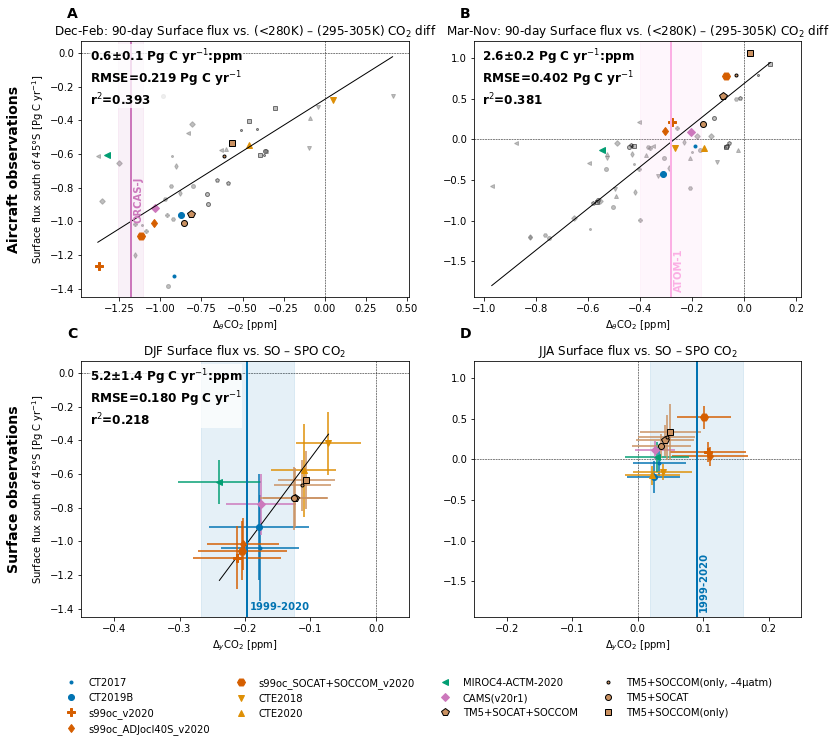

In [7]:
constraint_type = 'total_constraint'
fit_campaigns_tot, fit_ax_props_tot = plot_flux_v_gradient(constraint_type)
util.savefig(f'emergent-constraint-{constraint_type}.pdf')

**Emergent constraints on air-sea fluxes south of 45°S based on total CO<sub>2</sub>**. See  caption above for full explanation; the difference here is that we use total surface flux versus total CO<sub>2</sub>** and do not correct the observed gradients (colored vertical lines) for land and fossil-fuel components. Shading in these lines here solely indicates analytical uncertainties.

## Flux-gradient relation by campaign

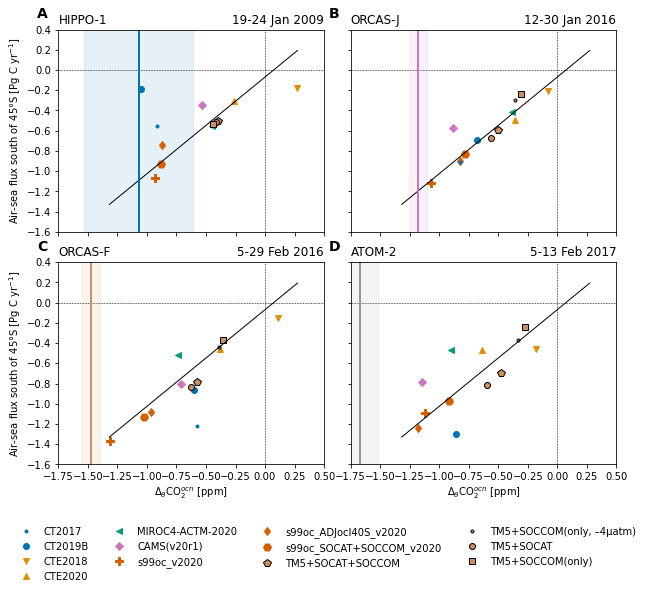

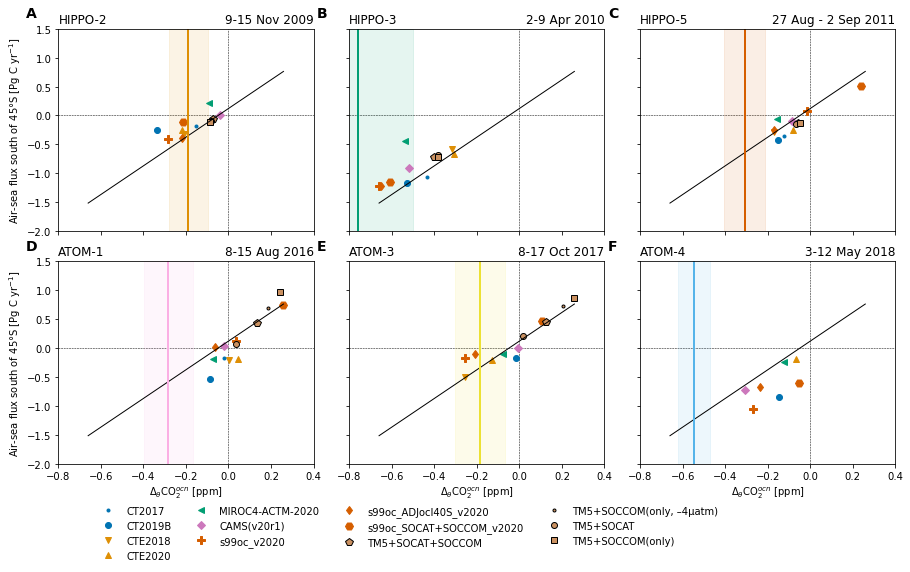

In [8]:
def plot_flux_v_gradient_by_campaign(constraint_type, fit_campaigns, fit_ax_props):

    ac = acs[constraint_type]
    fit_groups = ac.fit_groups
    campaign_info = obs_aircraft.get_campaign_info(verbose=False)
    figsize = (4.5, 4)
    
    for fit_group in fit_groups:

        plotted_elements = []
        legend_elements = []

        npanel = len(fit_campaigns[fit_group])
        fig, axs = util.canvas(
            npanel, 
            figsize=(5, 4),
            use_gridspec=True,
            #left=0, right=1, 
            #bottom=0., top=1,
            hspace=0.15, wspace=0.1+(npanel-4)*0.02,                           
        )
        nrow, ncol = axs.shape

        xmin = ac.df_data.xs((fit_group), level=('campaign_group')).gradient.min()
        xmax = ac.df_data.xs((fit_group), level=('campaign_group')).gradient.max()    

        if constraint_type == 'ocean_constraint':
            flux_type = 'Air-sea'
        else:
            flux_type = 'Surface'        
        str_co2 = 'CO$_2^{ocn}$' if constraint_type == 'ocean_constraint' else 'CO$_2$'
        
        ax_list = []
        for n, campaign in enumerate(fit_campaigns[fit_group]):
            i, j = np.unravel_index(n, axs.shape)
            ax = axs[i, j]
            ax_list.append(ax)

            xlabel = '$\Delta_{ θ}$' + str_co2 + ' [ppm]' if i == axs.shape[0]-1 else ''
            ylabel = f'{flux_type} flux south of 45°S [Pg C yr$^{{-1}}$]' if j == 0 else ''

            kwargs = dict(
                    title_left=campaign,
                    title_right=obs_aircraft.campaign_datestr(campaign_info[campaign]['time_bound']),
                    xlabel=xlabel,
                    ylabel=ylabel,
                    xhat=[xmin, xmax],
                    df_data=ac.df_data.xs((fit_group, campaign), level=('campaign_group', 'campaign')),
                    fit_dict=ec.get_fit_dict(ac.df_fits.loc[fit_group]),
                )

            le, pe, _ = ec.plot_constraint(ax, plotted_elements=plotted_elements,
                                           include_equation=False,
                                           **kwargs)

            ec.add_obs_constraint(
                ax=ax, 
                df=ac.vg_obs, 
                indexes=[campaign], 
                marker_spec=figure_panels.marker_spec_campaigns(),
            )

            legend_elements.extend(le)
            plotted_elements.extend(pe)

            plt.setp(ax, **fit_ax_props[fit_group])
            if j > 0:
                ax.set_yticklabels([])
            if i < nrow - 1:
                ax.set_xticklabels([])
        if len(fit_campaigns[fit_group]) == 4:
            axs[-1, -1].legend(handles=legend_elements, ncol=4, loc=(-1.275, -0.6), frameon=False)
        else:
            axs[-1, 1].legend(handles=legend_elements, ncol=4, loc=(-1., -0.5), frameon=False)

        util.label_plots(fig, ax_list, xoff=-0.03)        
        
        util.savefig(f'emergent-constraint-by-campaign-{fit_group}-{constraint_type}.pdf')
        
plot_flux_v_gradient_by_campaign('ocean_constraint', fit_campaigns_ocn, fit_ax_props_ocn)       

## Seasonal dependence of flux-gradient slope

In [9]:
constraint_type = 'ocean_constraint'
air_parms = dict(**ec.get_parameters('default'))
ac = obj_air[constraint_type].get_ac(**air_parms, clobber=False)

In [10]:
parms = dict(**ec.get_parameters('default'))
parms['fit_groups']=('DJF', 'MAM', 'JJA', 'SON')
ac_tmp = obj_air[constraint_type].get_ac(**parms, clobber=False)

DJF: 0.96 ± 0.10
MAM: 1.98 ± 0.41
JJA: 3.20 ± 0.31
SON: 2.40 ± 0.23
MAMJJASON: 2.48 ± 0.14


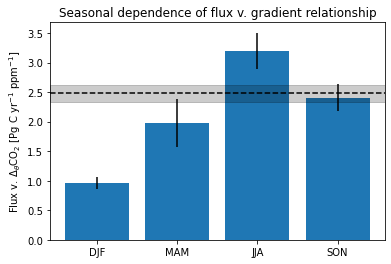

In [11]:
seasons = list(ac_tmp.fit_groups)
slopes = [beta[0] for beta in ac_tmp.df_fits.loc[seasons].fit_beta]
slope_err = [sd_beta[0] for sd_beta in ac_tmp.df_fits.loc[seasons].fit_stderr_beta]
plt.bar(seasons, slopes, yerr=slope_err);
plt.ylabel(r'Flux v. $\Delta_{ θ}$CO$_2$ [Pg C yr$^{{-1}}$ ppm$^{-1}$]')
plt.title('Seasonal dependence of flux v. gradient relationship');

slope_not_summer = ac.df_fits.loc['MAMJJASON'].fit_beta[0]
slope_err_not_summer = ac.df_fits.loc['MAMJJASON'].fit_stderr_beta[0]
plt.axhspan(
    slope_not_summer - slope_err_not_summer,
    slope_not_summer + slope_err_not_summer,
    color='k', alpha=0.2, zorder=1)    
plt.axhline(ac.df_fits.loc['MAMJJASON'].fit_beta[0], linestyle='--', color='k');

for season, s, s_err in zip(seasons, slopes, slope_err):
    print(f'{season}: {s:0.2f} ± {s_err:0.2f}')

print(f'MAMJJASON: {slope_not_summer:0.2f} ± {slope_err_not_summer:0.2f}') 

In [12]:
print(f'Seaonsal fit groups ann mean flux: {ac_tmp.estimate_ann_mean_flux[0]:0.2f} ± {ac_tmp.estimate_ann_mean_flux[1]:0.2f}')
print(f'Summer/not-summer fit groups ann mean flux: {ac.estimate_ann_mean_flux[0]:0.2f} ± {ac.estimate_ann_mean_flux[1]:0.2f}')

Seaonsal fit groups ann mean flux: -0.54 ± 0.34
Summer/not-summer fit groups ann mean flux: -0.55 ± 0.23
